In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
import os
import pathlib
import cv2

from PIL import Image
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from numpy import asarray
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model


from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import tensorflow_addons as tfa
from tensorflow.keras.models import Model
import tensorflow.keras as keras

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Check for TensorFlow GPU access
print(tf.config.list_physical_devices())

# See TensorFlow version
print(tf.__version__)
base_dir = 'C:/Users/phuong/Downloads/fruits-360_dataset/fruits-360/'
test_dir = os.path.join(base_dir, 'Test')
train_dir = os.path.join(base_dir, 'Training')
train_img_count = sum(len(files) for _, _, files in os.walk(train_dir))
test_img_count = sum(len(files) for _, _, files in os.walk(test_dir))

print(f'Number of files in the training folder: {train_img_count}')
print(f'Number of files in the test folder: {test_img_count}\n')

nr_classes = sorted((f for f in os.listdir(train_dir) if not f.startswith(".")), key=str.lower)

print(f'Number of classes: {len(nr_classes)}')
print(f'Names of classes: {nr_classes}')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
2.11.0-rc0
Number of files in the training folder: 67692
Number of files in the test folder: 22688

Number of classes: 131
Names of classes: ['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pin

In [2]:
train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir)

In [3]:
# Img size

img_height = 224
img_width = 224
BATCH_SIZE = 15

In [4]:
# Data preprocessing - ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,# Image augmentaion 
    shear_range=0.2,
    zoom_range=0.2, # Zoom in on image by 20%
    horizontal_flip=True, #  Flip the image horizontally
    validation_split=0.2) # Split 20% of the data for validation

# Normalize the test data images
test_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset='training') # Set as training data

validation_generator = train_datagen.flow_from_directory(
    train_dir, # Same directory as training data
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # Set as validation data

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical')

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [5]:
nb_train = len(train_generator.filenames)
nb_val = len(validation_generator.filenames)

resnet = VGG19(include_top=False, weights='imagenet', input_shape=(img_height,img_width,3),pooling='max')

output = resnet.layers[-1].output
output = tf.keras.layers.Flatten()(output)
resnet = Model(resnet.input, output)

In [6]:
for layer in resnet.layers:
    layer.trainable = False

In [7]:
resnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

num_classes = 131

model = Sequential()
model.add(resnet)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 512)               20024384  
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 131)               134275    
                                                                 
Total params: 20,683,971
Trainable params: 659,587
Non-trainable params: 20,024,384
_________________________________________________________________


In [9]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                              restore_best_weights=False
                                              )


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.3,
                                   patience=5,
                                   verbose=1,
                                   min_delta=1e-3,min_lr = 1e-7,
                                   )

In [10]:
model.compile(optimizer = adam, 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy',tfa.metrics.F1Score(num_classes=num_classes)])

In [13]:
model.fit(train_generator,steps_per_epoch=(nb_train) //(BATCH_SIZE),
                        epochs = 100,callbacks=[early_stop,reduce_lr],
                          validation_steps=(nb_val)//(BATCH_SIZE),
                        validation_data = validation_generator)

1694/1694 [==============================] - 16785s 10s/step - loss: 3.4369 - accuracy: 0.2777 - f1_score: 0.2536 - val_loss: 2.2487 - val_accuracy: 0.5912 - val_f1_score: 0.5553 - lr: 1.0000e-04


In [14]:
def get_diagnostic_plot(model,name):
    training_loss = model.history.history[name]
    test_loss = model.history.history[f'val_{name}']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend([f'Training {name}', f'Val {name}'])
    plt.xlabel('Epoch')
    plt.ylabel(name)

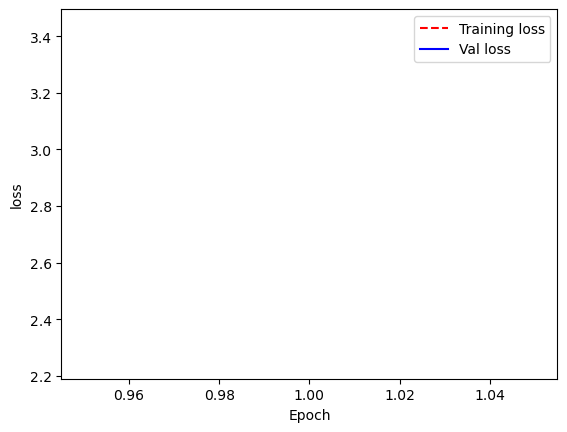

In [15]:
get_diagnostic_plot(model,'loss')

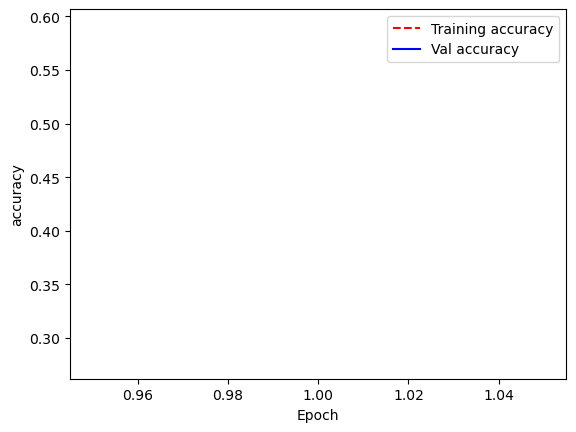

In [16]:
get_diagnostic_plot(model,'accuracy')